<Font size='7'>**Stock Price Prediction Using LSTM**</Font>

## Project Description

### **Objective**  
Predict future stock prices using machine learning and deep learning techniques, comparing the performance of XGBoost and LSTM models.  

### **Dataset**  
- Collected historical stock price data from **Yahoo Finance** (e.g., Apple - AAPL).  
- Used features like **Open, High, Low, Close, and Volume** for analysis.  

### **Preprocessing & Feature Engineering**  
- Checked for missing values and performed data cleaning.  
- Used **MinMaxScaler** for data normalization.  
- Conducted **stationarity tests** (ADF, KPSS) and seasonal decomposition.  

### **Modeling Approach**  

#### **XGBoost Model:**  
- Initially implemented **XGBoost**, a powerful gradient boosting algorithm.  
- Faced challenges with accuracy and time series pattern capture.  
- Due to limitations, explored a deep learning approach.  

#### **LSTM (Long Short-Term Memory) Model:**  
- Implemented **LSTM**, a type of **Recurrent Neural Network (RNN)** designed for time series forecasting.  
- Used **Bidirectional LSTM** for improved pattern recognition.  
- Added **Dropout layers** to prevent overfitting.  
- Optimized using the **RMSprop optimizer** and **Early Stopping**.  

### **Evaluation Metrics**  
- **Mean Squared Error (MSE)**  
- **Mean Absolute Error (MAE)**  
- **R² Score** for model performance assessment.  

### **Findings**  
- **XGBoost** struggled with sequential dependencies, leading to lower performance.  
- **LSTM** captured time series patterns better and provided more accurate predictions.  

### **Deployment**  
- Integrated the trained **LSTM model** into a **Streamlit web app** for real-time stock price predictions.  
- Allows users to enter a stock ticker and get predicted future prices.  


In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
# import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [30]:
ticker = 'AAPL'  # You can change this to any stock symbol
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=1440)).strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [31]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-03-01,125.146828,125.283931,120.250246,121.190389,116307900
2021-03-02,122.532043,126.057580,122.424318,125.753995,102260900
2021-03-03,119.535339,123.109845,119.319889,122.228459,112966300
2021-03-04,117.645248,121.043477,116.166486,119.231743,178155000
2021-03-05,118.908569,119.417818,115.138204,118.477675,153766600


In [32]:
data.shape

(991, 5)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 991 entries, 2021-03-01 to 2025-02-06
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   991 non-null    float64
 1   (High, AAPL)    991 non-null    float64
 2   (Low, AAPL)     991 non-null    float64
 3   (Open, AAPL)    991 non-null    float64
 4   (Volume, AAPL)  991 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 46.5 KB


In [34]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,991.000000,991.000000,991.000000,991.000000,9.910000e+02
mean,170.369586,171.984838,168.556188,170.182559,7.204016e+07
std,32.404521,32.506852,32.201857,32.361687,2.931566e+07
min,113.953232,117.909672,113.806333,116.568022,2.323470e+07
25%,145.695091,146.965957,143.876610,145.671677,5.127550e+07
50%,167.394302,168.930366,165.949521,167.733079,6.621320e+07
75%,187.768181,188.627880,186.443191,187.738642,8.626995e+07
max,259.019989,260.100006,257.630005,258.190002,3.186799e+08


In [35]:
data.isnull().sum()

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

<Font size='10'> **Time Series Analysis** </Font>

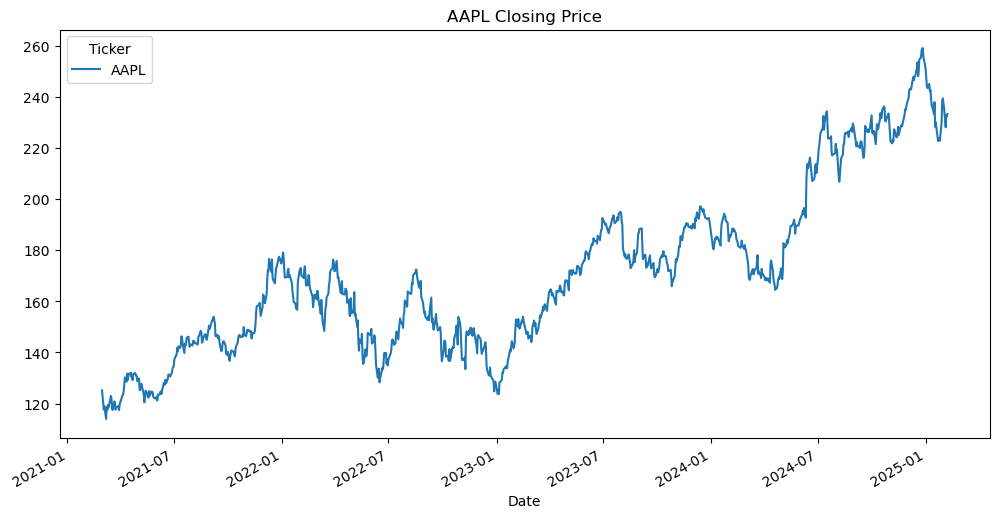

In [36]:
# Plotting closing price
data['Close'].plot(figsize=(12, 6), title=f'{ticker} Closing Price')
plt.show()

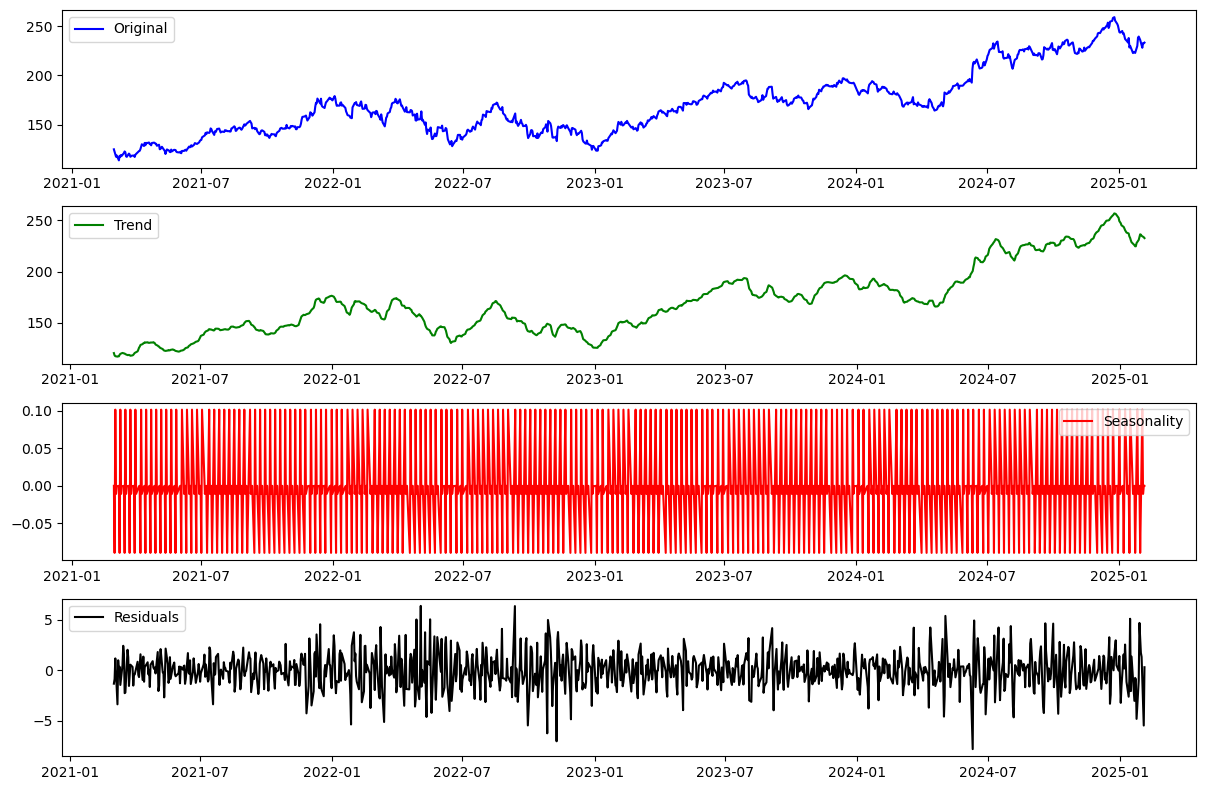

In [37]:
# Decompose time series
decomposition = seasonal_decompose(data['Close'], period=5, model='additive')

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(data['Close'], label='Original', color="blue")
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color="green")
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color="red")
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals',color="black")
plt.legend()
plt.tight_layout()
plt.show()

The given time series has been decomposed into three main components:

**1. Trend (Green Line)** --> We can see that the trend is upward.

**2. Seasonality (Red Line)** --> Here a clear repeating pattern is visible.

**3. Residuals (Black Line)** --> The Noise seems to be random, but we can see some patterns.

<Font size='10'> **Stationarity Test** </Font>

In [38]:
# Perform Augmented Dickey-Fuller (ADF) test for stationarity
adf_test = adfuller(data['Close'])

print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

if adf_test[1] <= 0.05:
    print("The time-series is stationary.")
else:
    print("The time-series is non-stationary.")

ADF Statistic: -0.9984742094633978
p-value: 0.7538203913476746
The time-series is non-stationary.


In [39]:
# Apply KPSS test
result_kpss = kpss(data['Close'], regression='c', nlags='auto')

# Print KPSS test results
print("\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
print(f"Test Statistic: {result_kpss[0]}")
print(f"p-value: {result_kpss[1]}")
print(f"Critical Values: {result_kpss[3]}")

# Conclusion
if result_kpss[1] > 0.05:
    print("The series is stationary")
else:
    print("The series is NOT stationary")


Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Test Statistic: 3.7436406068720816
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is NOT stationary


<Font size='10'>**xgboost**</Font>

In [40]:
import xgboost as xgb

In [41]:
#Feature Engineering for XGBoost
lag_features = 5
for lag in range(1, lag_features + 1):
    data[f'lag_{lag}'] = data['Close'].shift(lag)
data.dropna(inplace=True)


In [42]:
# Prepare XGBoost dataset
X = data[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
y = data['Close']
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [43]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test)


In [45]:
# Evaluate XGBoost model
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f'XGBoost MAE: {xgb_mae}')
print(f'XGBoost RMSE: {xgb_rmse}')
print(f'XGBoost R²: {xgb_r2}')


XGBoost MAE: 28.8348915793679
XGBoost RMSE: 32.86121037055531
XGBoost R²: -1.8425812432936044


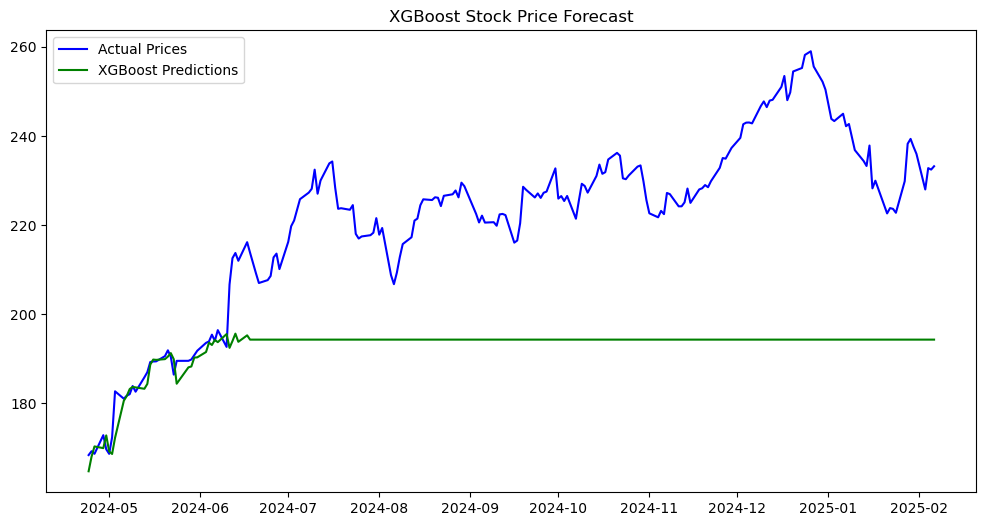

In [46]:
# Plot XGBoost predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], y_test, label='Actual Prices', color='blue')
plt.plot(data.index[train_size:], y_pred_xgb, label='XGBoost Predictions', color='green')
plt.legend()
plt.title('XGBoost Stock Price Forecast')
plt.show()

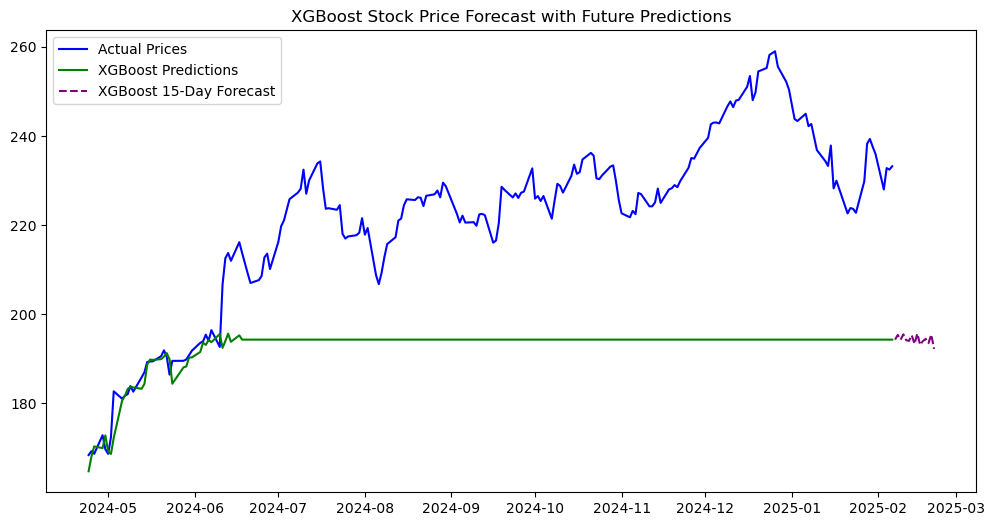

In [47]:
# Forecast next 15 days using XGBoost
last_features = X.iloc[-1].values.reshape(1, -1)
xgb_future_predictions = []
for _ in range(15):
    next_pred = xgb_model.predict(last_features)[0]
    xgb_future_predictions.append(next_pred)
    last_features = np.roll(last_features, -1)
    last_features[0, -1] = next_pred + np.random.normal(0, 0.05)  # Increased noise for variation

# Prepare dates for future predictions
dates_past = data.index[train_size:]
dates_future = [data.index[-1] + timedelta(days=i) for i in range(1, 16)]

# Plot combined actual, predicted, and future values
plt.figure(figsize=(12, 6))
plt.plot(dates_past, y_test, label='Actual Prices', color='blue')
plt.plot(dates_past, y_pred_xgb, label='XGBoost Predictions', color='green')
plt.plot(dates_future, xgb_future_predictions, label='XGBoost 15-Day Forecast', color='purple', linestyle='dashed')
plt.legend()
plt.title('XGBoost Stock Price Forecast with Future Predictions')
plt.show()

<Font size='10'>**LSTM**</Font>

In [48]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data[['Close']])

In [49]:
# Creating sequences for LSTM
sequence_length = 250
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

X_lstm, y_lstm = create_sequences(data_scaled, sequence_length)
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]


In [50]:
# LSTM Model definition
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1))),
    Dropout(0.1),
    Bidirectional(LSTM(100)),
    Dropout(0.1),
    Dense(1)
])

In [51]:
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='huber')


In [52]:
# Train LSTM model
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=8, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stop])


Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 279ms/step - loss: 0.0124 - val_loss: 0.0046
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 10/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - loss: 0.0019 - val_loss: 0.0062
Epoch 11/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 12/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 19

In [53]:
# Forecast using LSTM
predictions = model.predict(X_test_lstm)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step


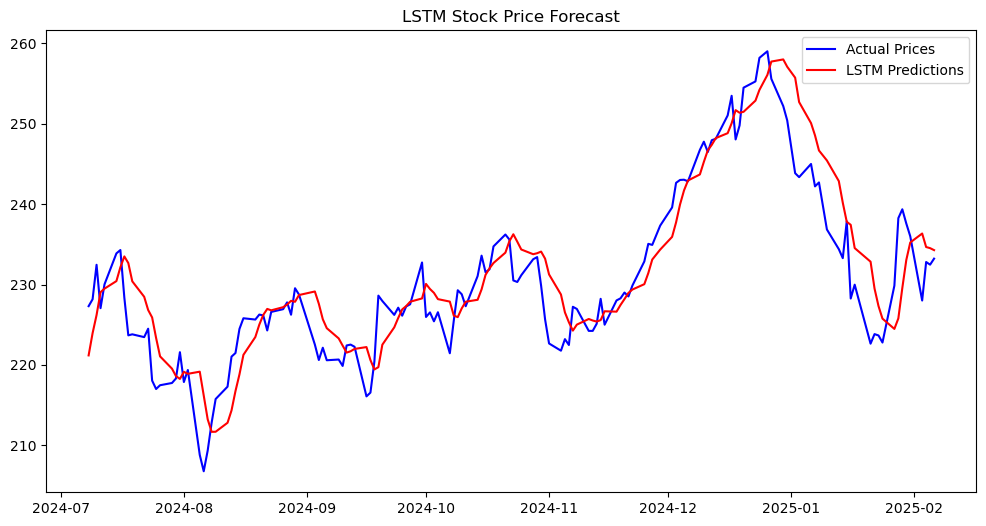

In [54]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+sequence_length:], y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(data.index[train_size+sequence_length:], predictions_rescaled, label='LSTM Predictions', color='red')
plt.legend()
plt.title('LSTM Stock Price Forecast')
plt.show()

In [55]:
# LSTM Evaluation
lstm_mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
lstm_rmse = mean_squared_error(y_test_rescaled, predictions_rescaled, squared=False)
print(f'LSTM MAE: {lstm_mae}')
print(f'LSTM RMSE: {lstm_rmse}')


LSTM MAE: 3.506844494793866
LSTM RMSE: 4.494185089695741


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


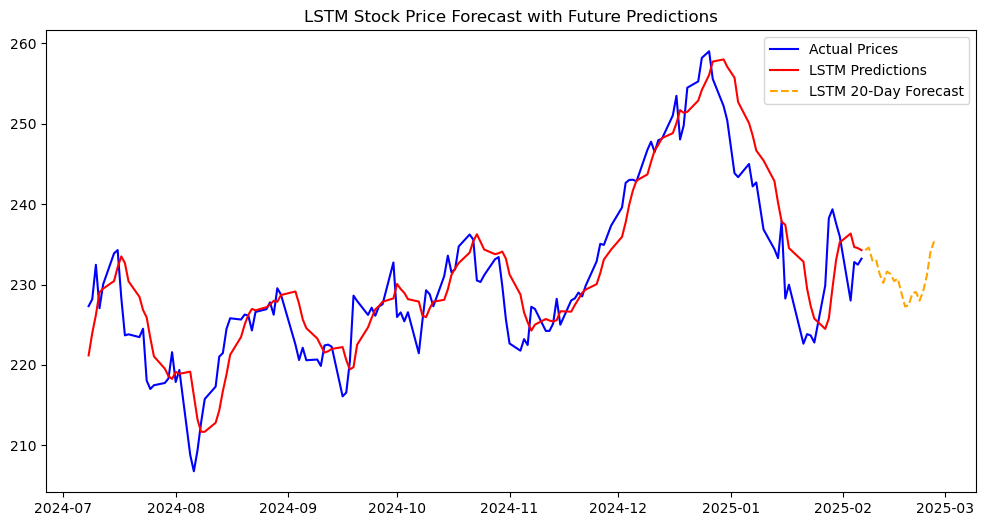

In [56]:
last_sequence = X_lstm[-1].reshape(1, sequence_length, 1)
future_predictions = []
for _ in range(20):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0][0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = next_pred[0][0] + np.random.normal(0, 0.05)  # Increased noise for variation

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare dates for future predictions
dates_past = data.index[train_size+sequence_length:]
dates_future = [data.index[-1] + timedelta(days=i) for i in range(1, 21)]

# Plot combined actual, predicted, and future values
plt.figure(figsize=(12, 6))
plt.plot(dates_past, y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(dates_past, predictions_rescaled, label='LSTM Predictions', color='red')
plt.plot(dates_future, future_predictions_rescaled, label='LSTM 20-Day Forecast', color='orange', linestyle='dashed')
plt.legend()
plt.title('LSTM Stock Price Forecast with Future Predictions')
plt.show()


In [57]:
# Save the trained LSTM model
model.save("lstm_stock_price_model.keras")  # Native Keras format

print("Model saved successfully!")


Model saved successfully!
